In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    confusion_matrix,
    classification_report
)
import time
import joblib
import shap
import eli5
from eli5.sklearn import PermutationImportance
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

np.random.seed(0)

In [2]:
df = pd.read_csv("Dataset_2_DATA.csv", encoding='cp1251')[lambda df: df['DAGSOORT'] == 1]
df_d = pd.read_csv("Dataset_2_DESCRIPTION.csv", encoding='cp1251')

## Подготовка данных

### 1. Обработка пропущенных значений 

In [3]:
# Проверяем датафрейм на содержание NaN-значений
has_any_missing = df.isna().any().any()
print("Есть ли NaN в датафрейме?", has_any_missing)

# Может показаться, что пропусков нет, но если проверить столбцы на соотвествие типу object можно понять,
# что два столбца потенциально могут содержать "нетипичные" пропуски.
print(df.dtypes[df.dtypes != 'int64'])

# Проверим уникальные значения столбцов KREISDUUR и PARKEERKOSTEN
for col in df.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения в {col}:")
    print(df[col].unique())

# Бинго! Пропуски в наборе данных обозначаются одним пробелом(' ')

Есть ли NaN в датафрейме? False
KREISDUUR        object
PARKEERKOSTEN    object
dtype: object
Уникальные значения в KREISDUUR:
['11' '8' '7' '5' '4' '3' '10' '6' '2' '9' ' ' '1']
Уникальные значения в PARKEERKOSTEN:
['0' '9' '3' '11' ' ' '13' '5' '4' '14' '12' '16' '10' '7' '2' '6' '1' '8']


In [4]:
# Заменяем пропуски на NaN-значение
df = df.replace({' ': np.nan})

# Функция для замены пропусков модой (или средним) значением
def fill_with_mode(group):
    mode_vals = group.mode()
    if not mode_vals.empty:
        return group.fillna(mode_vals.iloc[0])
    return group.fillna(group.mean())

# Заменяем пропуски в найденных столбцах
cols_to_fill = ['KREISDUUR', 'PARKEERKOSTEN']
for col in cols_to_fill:
    df[col] = df.groupby('PERSID')[col].transform(fill_with_mode)

### 2. Удаление дубликатов

In [5]:
df = df.drop_duplicates()
display(df) # Как можно заметить, количество строк не изменилось
print(len(df))

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,30862294,3086229401,19042102,1904210201,2,3,1,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,1,1,0,0,0,0,0,1,0,0


5700


In [61]:
df['province_route'] = df['VERTPROV'].astype(str) + '_' + df['AANKPROV'].astype(str)

df['KREISDUUR'] = pd.to_numeric(df['KREISDUUR'], errors='coerce')

duration_map = {
    1: 2.5, 2: 7.5, 3: 12.5, 4: 17.5, 5: 22.5, 6: 27.5, 
    7: 37.5, 8: 52.5, 9: 75, 10: 105, 11: 120
}
df['travel_duration'] = df['KREISDUUR'].map(duration_map)

display(df)

,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,VPLDAGNR,VERPL,VERPLNR,TOER,...,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE,province_route,travel_duration
0,2,3,2,1,2,2,1,3,1,0,...,0,0,1,0,0,1,0,1,0_0,120.0
1,2,3,2,1,2,2,1,3,2,0,...,0,0,1,0,0,1,0,1,0_0,52.5
2,2,3,1,1,2,4,2,3,1,0,...,0,0,1,0,0,1,0,1,0_0,37.5
3,2,3,1,1,2,4,2,3,2,0,...,0,0,1,0,0,1,0,1,0_0,22.5
7,2,3,8,1,2,1,1,3,1,1,...,0,0,0,0,0,0,0,1,0_0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,2,3,1,1,2,5,1,1,2,0,...,0,0,0,0,0,1,0,0,27_20,105.0
7306,2,3,7,1,2,5,1,1,3,0,...,0,0,0,0,0,1,0,0,20_20,7.5
7307,2,3,7,1,2,5,1,1,4,0,...,0,0,0,0,0,1,0,0,20_20,7.5
7308,2,3,1,1,2,3,2,1,1,0,...,0,0,0,0,0,1,0,0,22_20,27.5


### График 1 (Целевая переменная (KHVM))

/var/folders/6g/dz7v7l1x2_56ltfk7109p55m0000gn/T/ipykernel_69856/3454307680.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




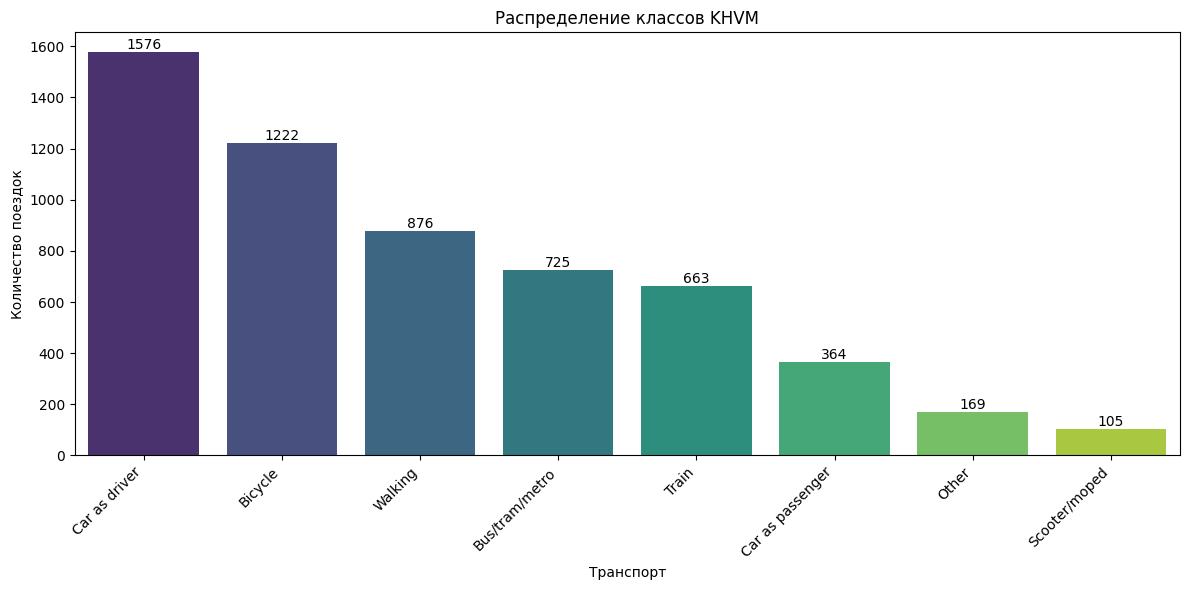

In [64]:
labels = {
    1: 'Car as driver',
    2: 'Car as passenger',
    3: 'Train',
    4: 'Bus/tram/metro',
    5: 'Scooter/moped',
    6: 'Bicycle',
    7: 'Walking',
    8: 'Other'
}

class_counts = df['KHVM'].value_counts().sort_values(ascending=False)
class_order = class_counts.index.tolist()

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='KHVM', data=df, order=class_order, palette='viridis')
plt.title('Распределение классов KHVM')
plt.xlabel('Транспорт')
plt.ylabel('Количество поездок')

plt.xticks(
    ticks=range(len(class_order)),
    labels=[labels[i] for i in class_order],
    rotation=45,
    ha='right'
)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), int(p.get_height()), 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

### График 2 (Основные характеристики поездок)

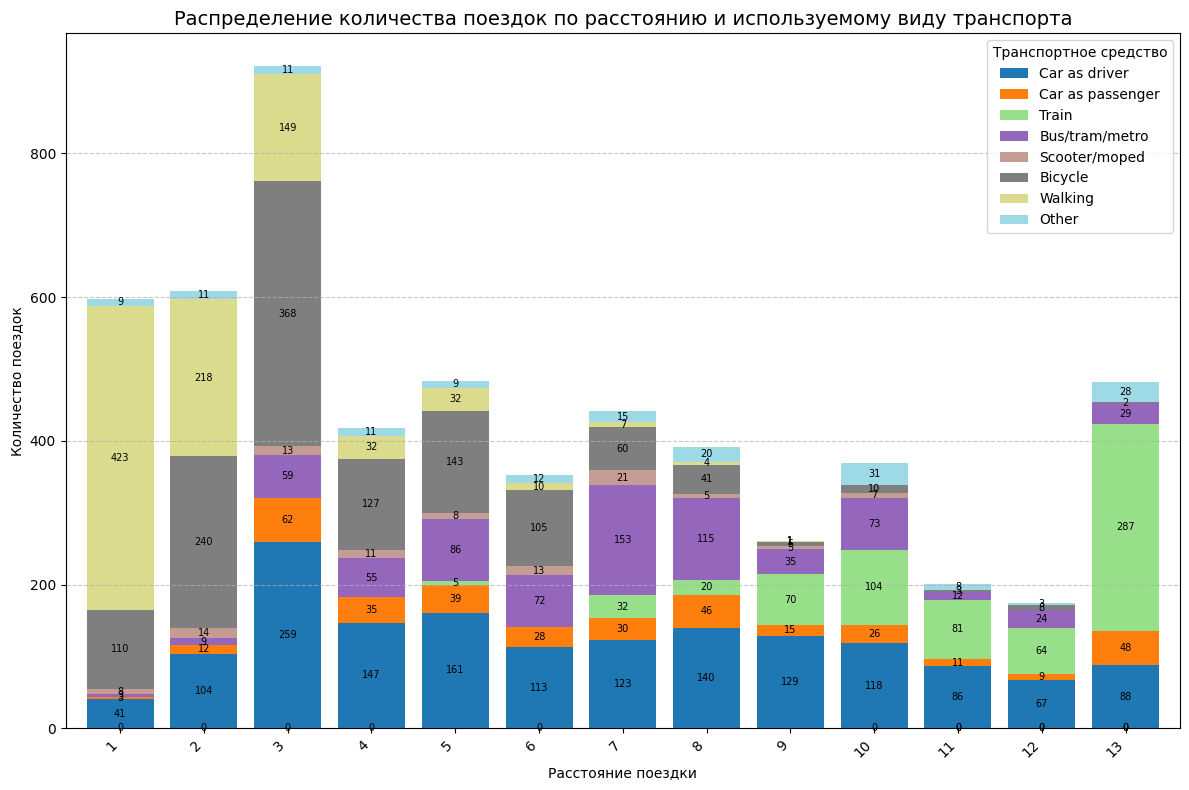

In [60]:
df1 = df.groupby(['KAFSTV', 'KHVM'], observed=False).size().reset_index().rename(
    columns={'KAFSTV': 'Расстояние поездки', 0: 'Количество поездок', 'KHVM': 'Транспортное средство'}
)

df1['Транспортное средство'] = df1['Транспортное средство'].map(labels)

pivot_df = df1.pivot(
    index='Расстояние поездки',
    columns='Транспортное средство',
    values='Количество поездок'
).fillna(0)

ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    width=0.8,
    colormap="tab20",
    legend=True
)

plt.title('Распределение количества поездок по расстоянию и используемому виду транспорта', fontsize=14)
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество поездок')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=7, color="black")

ax.set_xticklabels(list(pivot_df.index), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 3. Приведение типов данных

In [ ]:
# Для качественной работы LightAutoML нужно перевести int64-столбцы к category
# Получение признаков и их типов
var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

new_features = ['province_route']

var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

new_features_df = pd.DataFrame({
    'Variable': new_features,
    'Measurement_level': 'Nominal'
})
var_types = pd.concat([var_types, new_features_df], ignore_index=True).drop_duplicates(subset='Variable')

matched_columns = pd.DataFrame(df.columns, columns=['Variable'])
merged = matched_columns.merge(var_types, on='Variable', how='left')

nominal_cols = list(merged[merged['Measurement_level'] == 'Nominal']['Variable'])
ordinal_cols = list(merged[merged['Measurement_level'] == 'Ordinal']['Variable'])
scale_cols = list(merged[merged['Measurement_level'] == 'Scale']['Variable'])

id_cols = ['HHID', 'PERSID', 'VPLID', 'RitID']
df = df.drop(columns=id_cols, errors='ignore')

for col in nominal_cols + ordinal_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   HH_VALID                 5700 non-null   category
 1   P_VALID                  5700 non-null   category
 2   KHVM                     5700 non-null   category
 3   WEGGEWEEST               5700 non-null   category
 4   VERTREKP                 5700 non-null   category
 5   AANTVPL                  5700 non-null   category
 6   VPLDAGNR                 5700 non-null   category
 7   VERPL                    5700 non-null   category
 8   VERPLNR                  5700 non-null   category
 9   TOER                     5700 non-null   category
 10  TOER_TYPE                5700 non-null   category
 11  AANTRIT                  5700 non-null   category
 12  KMOTIEF                  5700 non-null   category
 13  VERTPROV                 5700 non-null   category
 14  AANKPROV     

#### **Целевая переменная (таргет):**
**`KHVM`** — класс основного вида транспорта для поездки. 

Категории:
1. Car as driver (Водитель автомобиля)
2. Car as passenger (Пассажир автомобиля)
3. Train (Поезд)
4. Bus/tram/metro (Автобус/трамвай/метро)
5. Scooter/moped (Скутер/мопед)
6. Bicycle (Велосипед)
7. Walking (Пешком)
8. Other (Другое).

#### 1. **Демографические и домохозяйственные данные:**
- **`HHSAM`** — состав домохозяйства (например, наличие детей может влиять на выбор транспорта).
- **`HHBRUTOINK2_w5`** — доход домохозяйства (высокий доход может коррелировать с использованием автомобиля).
- **`HHAUTO`, `HHBESTEL`, `HHHYBRID`, `HHMOTOR`, `HHBROM`, `HHSNOR`, `HHFIETS`, `HHVOUWFIETS`, `HHEBIKE`** — Наличие транспортных средств.

#### 2. **Географические и инфраструктурные данные:**
- **`STED_GM`** — уровень урбанизации (влияет на доступность общественного транспорта).
- **`PROV`** — провинция (региональные различия в транспортных привычках).
- **`vlokatie_station`** — расстояние до ближайшей ж/д станции.
- **`vlokatie_bushalte4xpu`** — расстояние до часто ходящего автобуса.

#### 3. **Характеристики поездки:**
- **`KAFSTV`** — класс расстояния поездки (короткие поездки чаще на велосипеде/пешком).
- **`KVERTTIJD`** — время начала поездки (пиковые часы могут влиять на выбор транспорта).
- **`DOEL`** — цель поездки (например, работа, шопинг).
- **`MOTIEF`** — мотив поездки (деловой, leisure и т.д.).
- **`TOER`** — является ли поездка круговой (может влиять на выбор транспорта).

#### 4. **Личные предпочтения и отношение к транспорту:**
- **`OORDEEL_AUTO`** — Оценка автомобиля.  
- **`OORDEEL_TREIN`** — Оценка поезда.  
- **`OORDEEL_BTM`** — Оценка общественного транспорта.  
- **`OORDEEL_FIETS`** — Оценка велосипеда.  
- **`OORDEEL_BROMMER`** — Оценка мопеда. 
- **`OORDEEL_LOPEN`** — Оценка ходьбы.
- **`GEBRUIK_AUTO_STELLING3` / `GEBRUIK_AUTO_STELLING4`** — Восприятие авто (экономия времени, безопасность). 
- **`GEBRUIK_TREIN_STELLING3` / `GEBRUIK_TREIN_STELLING4`** — Восприятие поезда.
- **`GEBRUIK_BTM_STELLING3` / `GEBRUIK_BTM_STELLING4`** — Восприятие общественного транспорта.
- **`GEBRUIK_FIETS_STELLING2` / `GEBRUIK_FIETS_STELLING3`** — Восприятие велосипеда.
- **`GEBRUIK_LOPEN_STELLING3` / `GEBRUIK_LOPEN_STELLING4`** — Восприятие ходьбы.

#### 5. **Данные о транспортных средствах:**
- **`ROLAUTO`** — роль в поездке (водитель/пассажир).
- **`PARKEERKOSTEN`** — стоимость парковки (может влиять на решение использовать автомобиль).

### График 8 (Матрица корреляции)

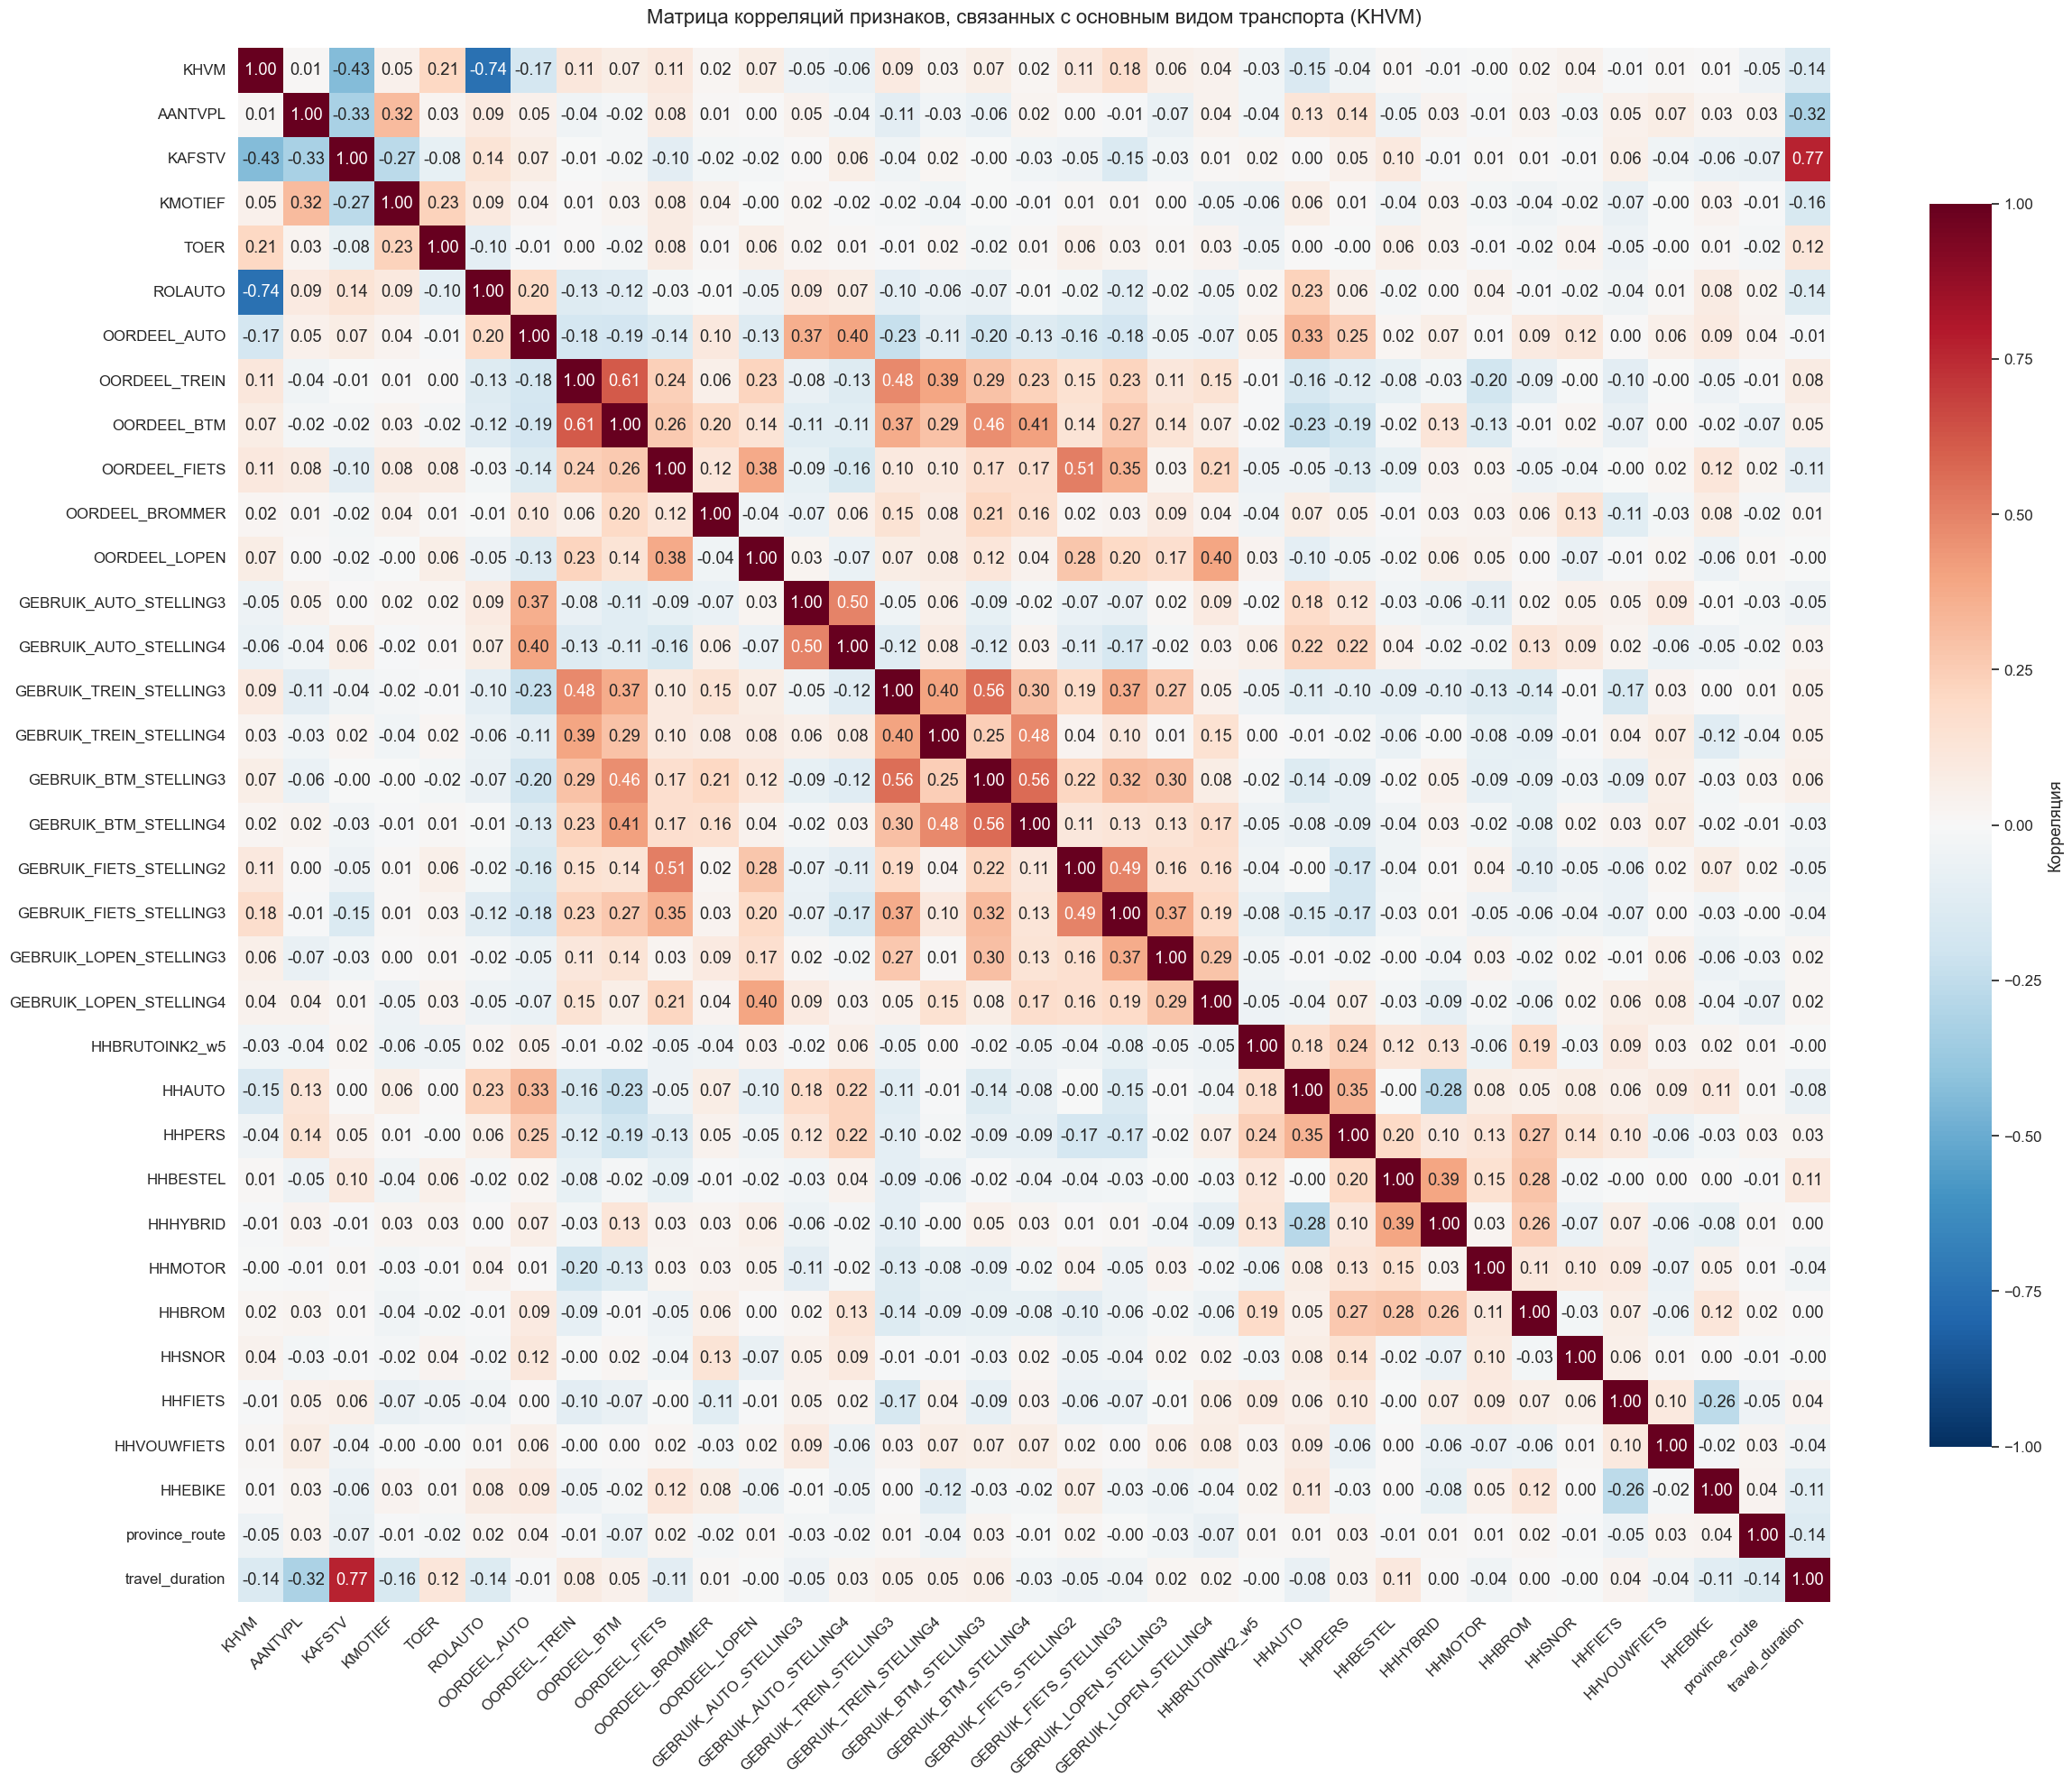

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Отфильтруем нужные столбцы
columns_of_interest = [
    'KHVM', 'AANTVPL', 'KAFSTV', 'KMOTIEF', 'TOER',
    'ROLAUTO', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM',
    'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN',
    'GEBRUIK_AUTO_STELLING3', 'GEBRUIK_AUTO_STELLING4',
    'GEBRUIK_TREIN_STELLING3', 'GEBRUIK_TREIN_STELLING4',
    'GEBRUIK_BTM_STELLING3', 'GEBRUIK_BTM_STELLING4',
    'GEBRUIK_FIETS_STELLING2', 'GEBRUIK_FIETS_STELLING3',
    'GEBRUIK_LOPEN_STELLING3', 'GEBRUIK_LOPEN_STELLING4',
    'HHBRUTOINK2_w5', 'HHAUTO', 'HHPERS', 'HHBESTEL', 
    'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR',
    'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE', 'province_route', 
    'travel_duration'
]

df_corr = df[columns_of_interest]

# 2. Рассчитаем корреляционную матрицу (числовые столбцы)
corr_matrix = df_corr.corr()

# 3. Построение графика
plt.figure(figsize=(25, 20))
sns.set(font_scale=1.1)

ax = sns.heatmap(
    corr_matrix, 
    annot=True,         # подписываем значения
    fmt=".2f",          # формат чисел
    cmap='RdBu_r',      # цветовая шкала
    vmin=-1, vmax=1,    # диапазон корреляции
    cbar_kws={'shrink': 0.8, 'label': 'Корреляция'}
)

plt.title('Матрица корреляций признаков, связанных с основным видом транспорта (KHVM)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Выводы:
1. `ROLAUTO` - высокая отрицательная корреляция −0.74. Звучит логично т.к. если ROLAUTO равен 1(пассажир) или 2(водитель), то значение таргета KHVM ниже - относится к классам 1 или 2, а не 3-8.
2. `KAFSTV` - средняя отрицательная корреляция -0,43. Так же объяснение лежит на поверхности: чем длиннее поездка (больше KAFSTV), тем больше людей выберут авто/поезд как вид транспорта (меньше KHVM).
3. `TOER` - умеренная положительная корреляция 0,21. Интерпретация может заключаться в том, что если маршрут круговой(прогулка, поездка на велосипеде, работа) люди предпочитают использовать KHVM с большими порядковыми числами(пешком, СИД и тд).

## 4. Разбиение на train/test выборки

Для задачи мультиклассовой классфикации таргета `KHVM` выберем стандартное деление 70% для train-выборки и 30% для test-выборки - компромисс между качественным обучением модели и надёжной валидацией её предсказательной способности.

In [10]:
target_name = 'KHVM'
y = df[target_name]
X = df.drop(columns=[target_name])


# Стратифицированное деление, чтобы сохранить баланс классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

print(pd.Series(y_res).value_counts())


KHVM
1    1103
2    1103
3    1103
4    1103
5    1103
6    1103
7    1103
8    1103
Name: count, dtype: int64


## AutoML (LightAutoML)

Для реализации AutoML-модели я выбрал библиотеку LAMA от братьев наших меньших из сбера.
Далее идет описание AutoML-пайплайна:

In [11]:
train_data = X_res.copy()
train_data[target_name] = y_res

categorical_columns = list(train_data.select_dtypes(include=['category']).columns)

task = Task('multiclass', metric='crossentropy')

roles = {
    'target': 'KHVM'
}

automl = TabularAutoML(
    task=task,
    timeout=1500,
    cpu_limit=1,
    memory_limit=12,
    reader_params={
        'n_jobs': 1,
        'cv': 5
    },
    lgb_params={
        'default_params': {
            'metric': 'multi_logloss',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 1000
        }
    },
    tuning_params={
        'max_iters': 20,
    }
)

start = time.time()
oof_preds = automl.fit_predict(train_data, roles=roles, verbose=1)
print("⏱ Обучение заняло:", round(time.time() - start, 2), "секунд")

joblib.dump(automl, "automl_khvm_model.joblib")
print("✅ Модель сохранена в 'automl_khvm_model.joblib'")


[23:00:06] Stdout logging level is INFO.
[23:00:06] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:00:06] Task: multiclass

[23:00:06] Start automl preset with listed constraints:
[23:00:06] - time: 1500.00 seconds
[23:00:06] - CPU: 1 cores
[23:00:06] - memory: 12 GB

[23:00:06] Train data shape: (8824, 54)

[23:00:07] Layer 1 train process start. Time left 1498.75 secs
[23:00:07] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:00:31] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.08290448243173355
[23:00:31] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:00:31] Time left 1474.42 secs

[23:00:36] Selector_LightGBM fitting and predicting completed
[23:00:36] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:01:04] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.03849282901812161
[23:01:04] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:01:04] Start hyperparameters optimizatio

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO	Task(Task-4) optuna.storages._in_memory:_in_memory.py:create_new_study()- A new study created in memory with name: no-name-e61c95c8-98d9-4f08-a725-60d7fec931b3
INFO	Task(Task-4) optuna.study.study:study.py:_log_completed_trial()- Trial 0 finished with value: -0.04346867383075271 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.04346867383075271.
Optimization Progress:  28%|██▊       | 28/101 [03:33<09:17,  7.64s/it, best_trial=26, best_value=-0.0387]

[23:04:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:04:38] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[23:04:48] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.0330057568490495
[23:04:48] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[23:04:48] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[23:07:12] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.035263648175280854
[23:07:12] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[23:07:12] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 146.95 secs


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO	Task(Task-4) optuna.storages._in_memory:_in_memory.py:create_new_study()- A new study created in memory with name: no-name-a28a9f30-193d-465a-a5dd-cd42562eb7d2
INFO	Task(Task-4) optuna.study.study:study.py:_log_completed_trial()- Trial 0 finished with value: -0.06270095639064631 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.06270095639064631.
Optimization Progress:   1%|          | 1/101 [00:30<51:21, 30.82s/it, best_trial=0, best_value=-0.0627]/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in a

[23:09:44] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[23:09:44] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[23:12:01] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.03415794704534108
[23:12:01] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[23:12:01] Time left 784.47 secs

[23:12:01] Layer 1 training completed.

[23:12:01] Layer 2 train process start. Time left 784.47 secs


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



[23:12:01] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[23:12:11] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.04503471843930206
[23:12:11] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:12:11] Time left 774.36 secs

[23:12:11] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[23:12:39] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.03849282901812161
[23:12:39] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:12:39] Time left 746.41 secs

[23:12:39] Layer 2 training completed.

[23:12:39] Blending: optimization starts with equal weights. Score = -0.0394268
[23:12:39] Blending: iteration 0: score = -0.0384626, weights = [0.06900223 0.9309978 ]
[23:12:39] Blending: no improvements for score. Terminated.

[23:12:39] Blending: best score = -0.0384626, best weights = [0.06900223 0.9309978 ]
[23:12:39] Automl preset training completed in 753.66 seconds

[23:12:39] Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod

Далее тестируем модель и расчитываем метрики

In [12]:
automl = joblib.load("automl_khvm_model.joblib")
# Предсказания
X_test_clean = X_test.copy()
test_preds = automl.predict(X_test_clean)

# Получаем метки классов в правильном порядке
class_labels = np.array(test_preds.features)  # список меток классов

# Обработка предсказаний
y_proba = test_preds.data  # вероятности
y_pred_idx = y_proba.argmax(axis=1)  # индексы наиболее вероятных классов
y_pred = class_labels[y_pred_idx]    # индексы → реальные метки

# Приводим y_true к тому же типу
y_true = y_test.astype(class_labels.dtype)

# Метрики
print("\n📊 Основные метрики:")
print(f"Accuracy:      {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro:      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Weighted:   {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss:      {log_loss(y_true, y_proba, labels=class_labels):.4f}")

print("\n🧩 Матрица ошибок:")
print(confusion_matrix(y_true, y_pred, labels=class_labels))

print("\n📝 Классификационный отчёт:")
print(classification_report(y_true, y_pred, labels=class_labels))



📊 Основные метрики:
Accuracy:      0.9661
F1 Macro:      0.9685
F1 Weighted:   0.9661
Log Loss:      0.0992

🧩 Матрица ошибок:
[[473   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0]
 [  0   0 199   0   0   0   0   0]
 [  0   0   0 217   0   0   0   0]
 [  0   0   0   0  30   1   0   0]
 [  0   0   0   0   0 341  24   2]
 [  0   0   0   0   0  27 236   0]
 [  0   0   0   0   0   4   0  47]]

📝 Классификационный отчёт:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       473
           2       1.00      1.00      1.00       109
           3       1.00      1.00      1.00       199
           4       1.00      1.00      1.00       217
           5       1.00      0.97      0.98        31
           6       0.91      0.93      0.92       367
           7       0.91      0.90      0.90       263
           8       0.96      0.92      0.94        51

    accuracy                           0.97      1710
   macro avg       0.

# Самописная модель

Моя модель будет состоять из Catboost, XGBoost, LightGBM и Random Forest.

Далее идет подготовка данных для обучения моделей классификации с учётом дисбаланса классов и особенностей категориальных признаков.

In [67]:
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

# Кодирование таргета
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Категориальные признаки
categorical_columns = X_train.select_dtypes(include=["category"]).columns.tolist()

# Подготовка данных для моделей, которые не поддерживают категориальные признаки напрямую
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

for col in categorical_columns:
    le_col = LabelEncoder()
    unique_values = np.unique(
        np.concatenate([X_train[col].astype(str), X_test[col].astype(str)])
    )
    le_col.fit(unique_values)
    X_train_rf[col] = le_col.transform(X_train[col].astype(str))
    X_test_rf[col] = le_col.transform(X_test[col].astype(str))

# Преобразование категориальных столбцов в строки для CatBoost
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
for col in categorical_columns:
    X_train_cat[col] = X_train_cat[col].astype(str)
    X_test_cat[col] = X_test_cat[col].astype(str)

Обучение базовых моделей классификации и создание мета-признаков для последующего стекинга.

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    early_stopping_rounds=50,
    eval_metric='MultiClass',
    loss_function='MultiClass',
    task_type='CPU',
    cat_features=categorical_columns,
    verbose=100
)
xgboost_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    enable_categorical=True
)
lightgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.2,
    class_weight='balanced',
    max_bin=200,
    device='cpu',
    num_threads=7
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

models = [catboost_model, xgboost_model, lightgbm_model, rf_model]

# Кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_classes = len(np.unique(y_train_encoded))
train_meta = np.zeros((X_train.shape[0], 4 * n_classes))
test_meta = np.zeros((X_test.shape[0], 4 * n_classes, 5))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
    print(f"Fold {fold+1}")
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_tr_rf, X_val_rf = X_train_rf.iloc[train_idx], X_train_rf.iloc[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    for i, model in enumerate(models):
        model_name = type(model).__name__
        print(f"  Training model: {model_name}")

        if isinstance(model, CatBoostClassifier):
            train_pool = Pool(X_tr_raw, y_tr, cat_features=categorical_columns)
            val_pool = Pool(X_val_raw, y_val, cat_features=categorical_columns)
            model.fit(train_pool, eval_set=val_pool)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_raw)
            test_meta[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test)

        elif isinstance(model, RandomForestClassifier):
            model.fit(X_tr_rf, y_tr)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_rf)
            test_meta[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test_rf)

        else:  # XGBoost и LightGBM
            model.fit(X_tr_rf, y_tr)
            train_meta[val_idx, i*n_classes:(i+1)*n_classes] = model.predict_proba(X_val_rf)
            test_meta[:, i*n_classes:(i+1)*n_classes, fold] = model.predict_proba(X_test_rf)

# Усреднение по фолдам
test_meta = test_meta.mean(axis=2)

for i, model in enumerate(models):
    joblib.dump(model, f'base_model_{i}.pkl')

Fold 1
  Training model: CatBoostClassifier
0:	learn: 1.9000824	test: 1.8974875	best: 1.8974875 (0)	total: 287ms	remaining: 4m 47s
100:	learn: 0.3788256	test: 0.3973011	best: 0.3973011 (100)	total: 23.7s	remaining: 3m 30s
200:	learn: 0.2665479	test: 0.3073729	best: 0.3073729 (200)	total: 47.9s	remaining: 3m 10s
300:	learn: 0.2153466	test: 0.2685725	best: 0.2685725 (300)	total: 1m 12s	remaining: 2m 47s
400:	learn: 0.1862720	test: 0.2474549	best: 0.2474549 (400)	total: 1m 36s	remaining: 2m 23s
500:	learn: 0.1677504	test: 0.2364063	best: 0.2364063 (500)	total: 2m	remaining: 2m
600:	learn: 0.1530936	test: 0.2274174	best: 0.2274174 (600)	total: 2m 26s	remaining: 1m 36s
700:	learn: 0.1372252	test: 0.2176305	best: 0.2176305 (700)	total: 2m 51s	remaining: 1m 13s
800:	learn: 0.1252364	test: 0.2110900	best: 0.2110900 (800)	total: 3m 17s	remaining: 49.1s
900:	learn: 0.1142950	test: 0.2049370	best: 0.2049346 (899)	total: 3m 43s	remaining: 24.6s
999:	learn: 0.1045845	test: 0.1981306	best: 0.1981306

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
categorical_columns = [col for col in X_train.select_dtypes(include=["object", "category"]).columns if col != 'KHVM']
X_train_enc[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_test_enc[categorical_columns] = encoder.transform(X_test[categorical_columns])

X_train_sets = [
    X_train,        # CatBoost
    X_train,        # XGBoost
    X_train_enc,    # LightGBM
    X_train_enc     # RandomForest
]
X_test_sets = [
    X_test,         # CatBoost
    X_test,         # XGBoost
    X_test_enc,     # LightGBM
    X_test_enc      # RandomForest
]


models = [joblib.load(f'base_model_{i}.pkl') for i in range(4)]
n_classes = 8


def generate_meta_features(models, X_train_sets, X_test_sets, y_train_encoded, n_classes=8, n_folds=5):
    n_models = len(models)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    train_meta = np.zeros((X_train_sets[0].shape[0], n_models * n_classes))
    test_meta_folds = np.zeros((X_test_sets[0].shape[0], n_models * n_classes, n_folds))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_sets[0], y_train_encoded)):
        for i, model in enumerate(models):
            X_val = X_train_sets[i].iloc[val_idx]
            test_pred = model.predict_proba(X_test_sets[i])
            val_pred = model.predict_proba(X_val)

            train_meta[val_idx, i * n_classes:(i + 1) * n_classes] = val_pred
            test_meta_folds[:, i * n_classes:(i + 1) * n_classes, fold] = test_pred

    test_meta = test_meta_folds.mean(axis=2)
    return train_meta, test_meta


### Генерация мета-признаков

In [85]:
train_meta, test_meta = generate_meta_features(
    models=models,
    X_train_sets=X_train_sets,
    X_test_sets=X_test_sets,
    y_train_encoded=y_train_encoded,
    n_classes=n_classes
)

### Расчет метрик по фолдам

In [86]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X_train_sets[0], y_train_encoded)):
    print(f"\nFold {fold + 1}")
    for i, model_name in enumerate(['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest']):
        y_pred = train_meta[val_idx, i*n_classes:(i+1)*n_classes]
        y_pred_sum = y_pred.sum(axis=1, keepdims=True)
        y_pred_sum[y_pred_sum == 0] = 1e-10
        y_pred = y_pred / y_pred_sum
        log_loss_score = log_loss(y_train_encoded[val_idx], y_pred, labels=range(n_classes))
        accuracy = accuracy_score(y_train_encoded[val_idx], y_pred.argmax(axis=1))
        print(f"{model_name} Log Loss: {log_loss_score:.4f}")
        print(f"{model_name} Accuracy: {accuracy:.4f}")


Fold 1
CatBoost Log Loss: 0.1405
CatBoost Accuracy: 0.9574
XGBoost Log Loss: 0.3948
XGBoost Accuracy: 0.8496
LightGBM Log Loss: 0.4893
LightGBM Accuracy: 0.8070
RandomForest Log Loss: 0.4822
RandomForest Accuracy: 0.9361

Fold 2
CatBoost Log Loss: 0.1311
CatBoost Accuracy: 0.9687
XGBoost Log Loss: 0.3462
XGBoost Accuracy: 0.8734
LightGBM Log Loss: 0.4333
LightGBM Accuracy: 0.8308
RandomForest Log Loss: 0.4793
RandomForest Accuracy: 0.9486

Fold 3
CatBoost Log Loss: 0.1340
CatBoost Accuracy: 0.9586
XGBoost Log Loss: 0.3877
XGBoost Accuracy: 0.8559
LightGBM Log Loss: 0.4743
LightGBM Accuracy: 0.8221
RandomForest Log Loss: 0.4818
RandomForest Accuracy: 0.9323

Fold 4
CatBoost Log Loss: 0.1394
CatBoost Accuracy: 0.9561
XGBoost Log Loss: 0.4028
XGBoost Accuracy: 0.8421
LightGBM Log Loss: 0.5004
LightGBM Accuracy: 0.8095
RandomForest Log Loss: 0.4952
RandomForest Accuracy: 0.9386

Fold 5
CatBoost Log Loss: 0.1971
CatBoost Accuracy: 0.9273
XGBoost Log Loss: 0.3957
XGBoost Accuracy: 0.8584
Li

### Обучение мета-моделей и сохранение ансамбля

In [ ]:
numerical_columns = X_train.select_dtypes(
    include=["int", "float", "bool"]
).columns.tolist()
categorical_columns = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_columns,
        ),
        ("num", "passthrough", numerical_columns),
    ],
    remainder="passthrough",
)

X_train_cat = X_train_cat[X_test_cat.columns]  # Синхронизация столбцов

catboost_pipeline = Pipeline(
    [("model", catboost_model)]
)  # CatBoost работает с X_train_cat
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_columns,
        ),
        ("num", "passthrough", X_train.columns.difference(categorical_columns)),
    ],
    remainder="passthrough",
)
xgb_pipeline = Pipeline([("preprocess", preprocessor), ("model", xgboost_model)])
lgbm_pipeline = Pipeline([("preprocess", preprocessor), ("model", lightgbm_model)])
rf_pipeline = Pipeline([("preprocess", preprocessor), ("model", rf_model)])

# Стекинг
stack = StackingClassifier(
    estimators=[
        ("catboost", catboost_pipeline),
        ("xgb", xgb_pipeline),
        ("lgbm", lgbm_pipeline),
        ("rf", rf_pipeline),
    ],
    final_estimator=CatBoostClassifier(iterations=200, learning_rate=0.03, verbose=0),
    cv=3,
    stack_method="predict_proba",
)

stack.fit(X_train_cat, y_train_encoded)
joblib.dump(stack, "stacking_model.pkl")
print("Модель сохранена в 'stacking_model.pkl'")

0:	learn: 1.8948350	total: 137ms	remaining: 2m 17s
100:	learn: 0.3584838	total: 25.4s	remaining: 3m 46s
200:	learn: 0.2645766	total: 52s	remaining: 3m 26s
300:	learn: 0.2179937	total: 1m 19s	remaining: 3m 4s
400:	learn: 0.1906428	total: 1m 47s	remaining: 2m 40s
500:	learn: 0.1698144	total: 2m 16s	remaining: 2m 15s
600:	learn: 0.1539553	total: 2m 44s	remaining: 1m 49s
700:	learn: 0.1396565	total: 3m 13s	remaining: 1m 22s
800:	learn: 0.1286820	total: 3m 42s	remaining: 55.3s
900:	learn: 0.1184177	total: 4m 11s	remaining: 27.7s
999:	learn: 0.1091554	total: 4m 40s	remaining: 0us
0:	learn: 1.9000348	total: 180ms	remaining: 3m
100:	learn: 0.3781407	total: 23.4s	remaining: 3m 28s
200:	learn: 0.2759248	total: 47.6s	remaining: 3m 9s
300:	learn: 0.2235759	total: 1m 12s	remaining: 2m 47s
400:	learn: 0.1911544	total: 1m 36s	remaining: 2m 24s
500:	learn: 0.1667833	total: 2m 1s	remaining: 2m
600:	learn: 0.1484419	total: 2m 25s	remaining: 1m 36s
700:	learn: 0.1314906	total: 2m 50s	remaining: 1m 12s
80

### Расчет метрик для итоговой модели

In [87]:
stack = joblib.load('stacking_model.pkl')

y_test_pred = stack.predict(X_test_cat)
y_test_pred_proba = stack.predict_proba(X_test_cat)

accuracy = accuracy_score(y_test_encoded, y_test_pred)
report = classification_report(y_test_encoded, y_test_pred, digits=4, output_dict=True)
macro_avg_f1 = report["macro avg"]["f1-score"]
weighted_avg_f1 = report["weighted avg"]["f1-score"]
logloss = log_loss(y_test_encoded, y_test_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Avg F1: {macro_avg_f1:.4f}")
print(f"Weighted Avg F1: {weighted_avg_f1:.4f}")
print(f"Log Loss: {logloss:.4f}")

Accuracy: 0.9737
Macro Avg F1: 0.9787
Weighted Avg F1: 0.9737
Log Loss: 0.0997


/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



### Глобальная интерпретация с SHAP

ELI5: интерпретируем базовые модели (CatBoost, XGBoost, LightGBM) по исходным признакам.

SHAP: интерпретируем мета-классификатор LightGBM, который принимает предсказания базовых моделей как признаки.

CatBoost Feature Importance:


Weight,Feature
0.2362,ROLAUTO
0.2045,AANTRIT
0.1036,KAFSTV
0.0360,KMOTIEF
0.0320,OORDEEL_BROMMER
0.0316,KREISDUUR
0.0272,HHAUTO_N
0.0242,OORDEEL_FIETS
0.0202,OORDEEL_LOPEN
0.0188,HHBRUTOINK2_w5


XGBoost Feature Importance:


Weight,Feature
0.3757,cat__ROLAUTO
0.1196,cat__AANTRIT
0.0710,cat__VERPL
0.0688,cat__TOER_TYPE
0.0496,cat__TOER
0.0206,cat__KAFSTV
0.0198,cat__VERTPROV
0.0178,cat__HHSNOR
0.0145,cat__AANKPROV
0.0138,cat__province_route


LightGBM Feature Importance:


Weight,Feature
0.2783,cat__ROLAUTO
0.1563,cat__AANTRIT
0.1010,cat__KAFSTV
0.0408,cat__OORDEEL_BROMMER
0.0349,num__travel_duration
0.0339,cat__HHSNOR
0.0238,cat__HHBROM
0.0220,cat__KMOTIEF
0.0185,cat__GEBRUIK_FIETS_STELLING2
0.0180,cat__HHBRUTOINK2_w5


RandomForest Feature Importance:


Weight,Feature
0.2024 ± 0.1150,cat__ROLAUTO
0.0807 ± 0.0745,cat__AANTRIT
0.0758 ± 0.0489,cat__KAFSTV
0.0443 ± 0.0447,num__travel_duration
0.0338 ± 0.0416,cat__HHSNOR
0.0312 ± 0.0596,cat__VERPL
0.0288 ± 0.0332,cat__OORDEEL_BROMMER
0.0276 ± 0.0222,cat__KMOTIEF
0.0252 ± 0.0305,cat__KREISDUUR
0.0234 ± 0.0205,cat__GEBRUIK_FIETS_STELLING2


/var/folders/6g/dz7v7l1x2_56ltfk7109p55m0000gn/T/ipykernel_69856/567684741.py:30: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



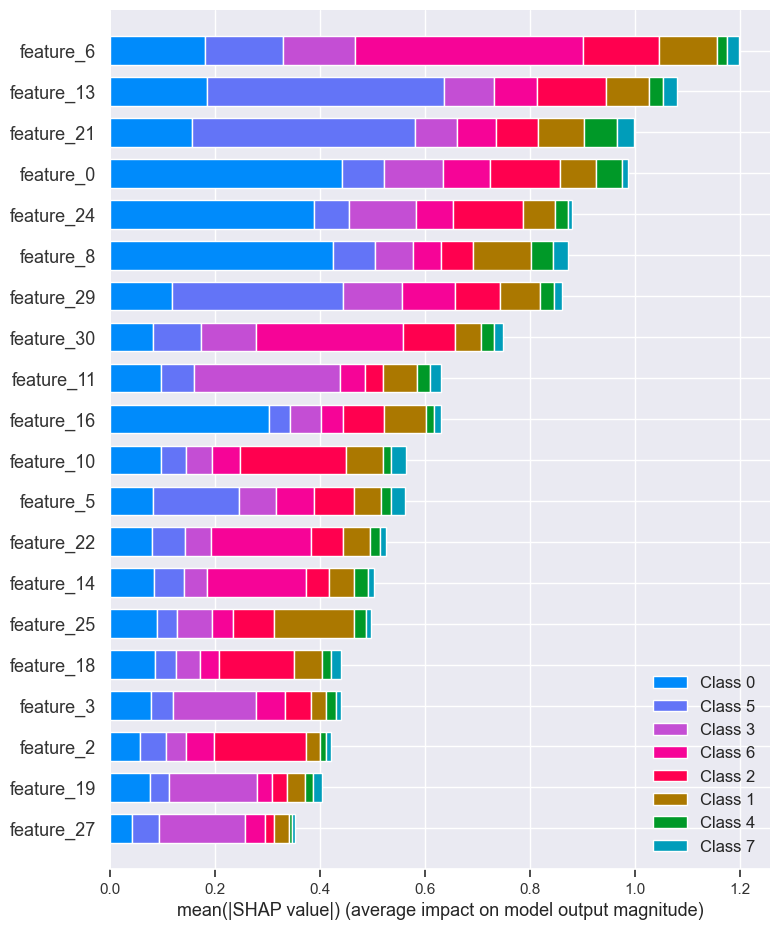

/var/folders/6g/dz7v7l1x2_56ltfk7109p55m0000gn/T/ipykernel_69856/567684741.py:34: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



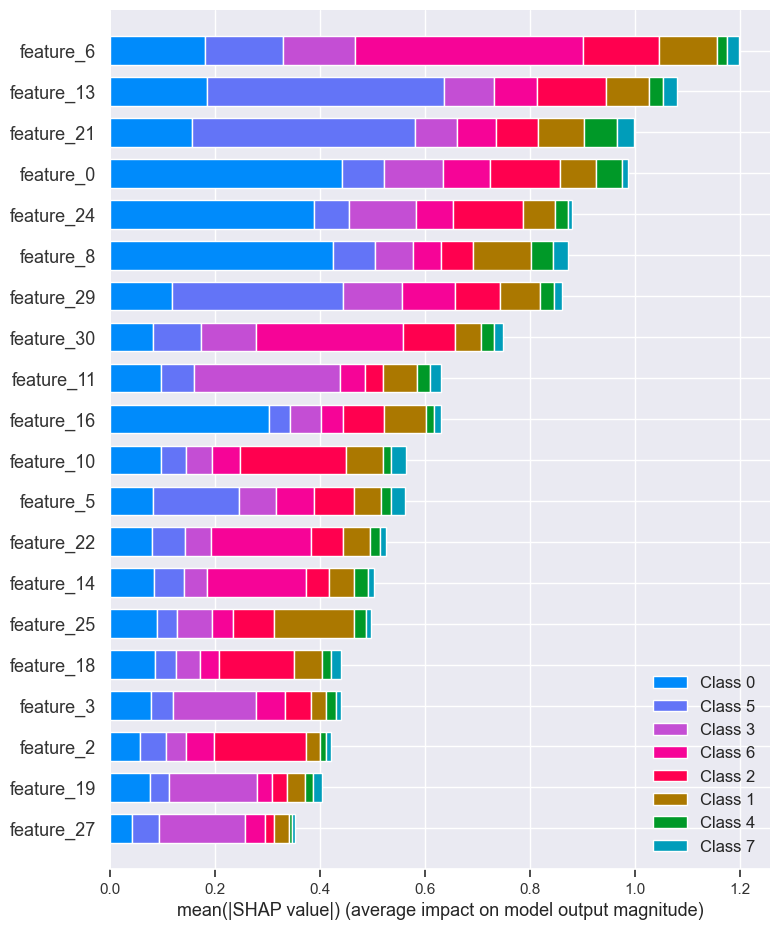

In [ ]:
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("CatBoost Feature Importance:")
display(eli5.show_weights(catboost_model, feature_names=X_train.columns.tolist()))

print("XGBoost Feature Importance:")
display(eli5.show_weights(xgboost_model, feature_names=X_train.columns.tolist()))

print("LightGBM Feature Importance:")
display(eli5.show_weights(lightgbm_model, feature_names=X_train.columns.tolist()))

print("RandomForest Feature Importance:")
display(eli5.show_weights(rf_model, feature_names=X_train.columns.tolist()))



X_test_meta = stack.transform(X_test)
X_test_meta_df = pd.DataFrame(X_test_meta, columns=[f"feature_{i}" for i in range(X_test_meta.shape[1])])

# SHAP для мета-классификатора
explainer_meta = shap.Explainer(stack.final_estimator_)
shap_values_meta = explainer_meta(X_test_meta_df)

# SHAP Summary Plot (бар-график)
plt.title("SHAP Summary Plot for Meta Classifier (LightGBM)")
shap.summary_plot(shap_values_meta, X_test_meta_df, plot_type="bar")

# SHAP Summary Plot (дот-график)
plt.title("SHAP Dot Plot for Meta Classifier (LightGBM)")
shap.summary_plot(shap_values_meta, X_test_meta_df)
    



=== LIME Объяснение для экземпляра с индексом 2541 (истинный класс: 1) ===


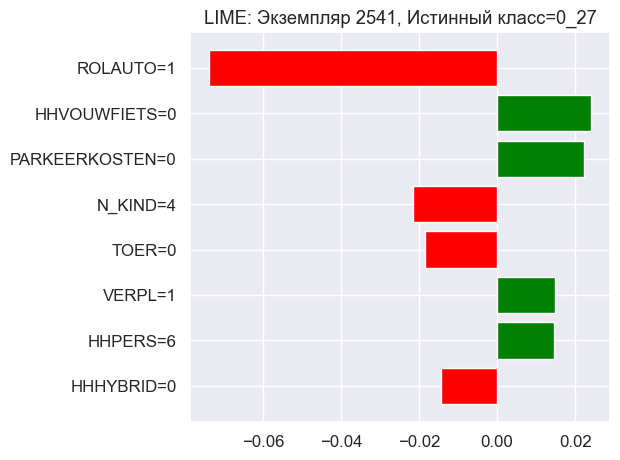



=== LIME Объяснение для экземпляра с индексом 4335 (истинный класс: 6) ===


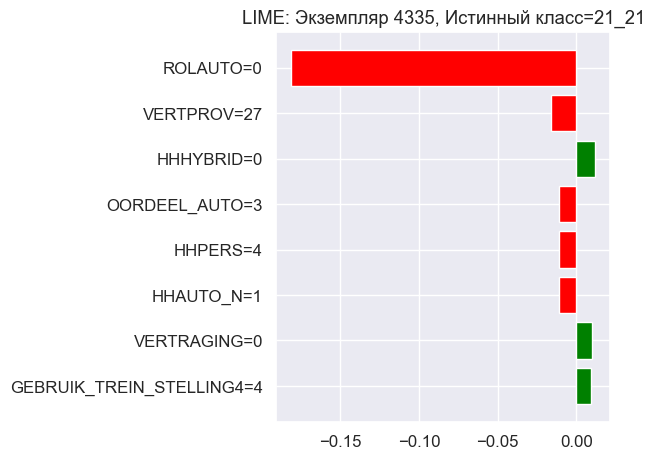



=== LIME Объяснение для экземпляра с индексом 3669 (истинный класс: 3) ===


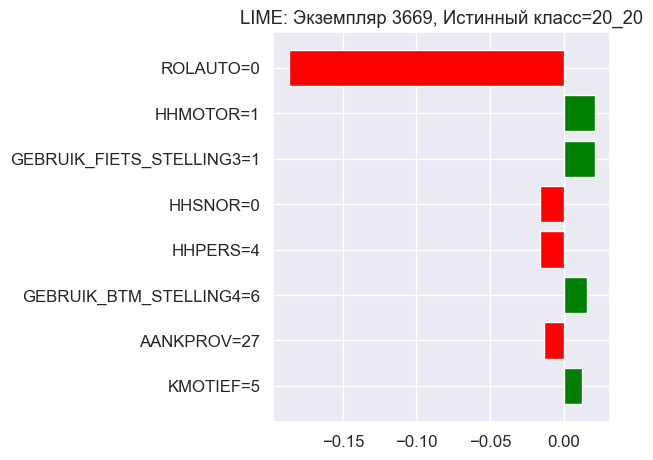

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

X_train_lime = X_train.copy()
X_test_lime = X_test.copy()

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_features = [X_train.columns.get_loc(col) for col in categorical_columns]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    combined = pd.concat([X_train_lime[col], X_test_lime[col]], axis=0)
    le.fit(combined)
    X_train_lime[col] = le.transform(X_train_lime[col])
    X_test_lime[col] = le.transform(X_test_lime[col])
    label_encoders[col] = le

X_train_lime = X_train_lime.astype(float)
X_test_lime = X_test_lime.astype(float)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_lime.values,
    feature_names=X_train_lime.columns.tolist(),
    class_names=le.classes_.tolist(),
    mode='classification',
    categorical_features=categorical_features,
    categorical_names={i: label_encoders[col].classes_.tolist() for i, col in zip(categorical_features, categorical_columns)},
    discretize_continuous=True,
    random_state=42
)

def custom_predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train_lime.columns)
    
    for col in categorical_columns:
        X_df[col] = label_encoders[col].inverse_transform(X_df[col].astype(int))
        X_df[col] = X_df[col].astype(str)
    
    return stack.predict_proba(X_df)

sample_indices = np.random.choice(X_test_lime.index, size=3, replace=False)

for idx in sample_indices:
    x_instance = X_test_lime.loc[idx].values
    true_class = y_test.loc[idx]
    
    print(f"\n\n=== LIME Объяснение для экземпляра с индексом {idx} (истинный класс: {true_class}) ===")
    
    exp = explainer_lime.explain_instance(
        data_row=x_instance,
        predict_fn=custom_predict_proba,
        num_features=8,
        num_samples=5000
    )
    
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME: Экземпляр {idx}, Истинный класс={le.inverse_transform([true_class])[0]}")
    plt.tight_layout()
    plt.show()